In [1]:
!pip install torch torchvision scikit-learn matplotlib ultralytics umap


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.3 MB/s eta 0:00:00
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3541 sha256=da48e

In [2]:
import os, json, yaml, math, gc, random, shutil, contextlib
from pathlib import Path
from PIL import Image
import xml.etree.ElementTree as ET
import shutil, yaml, math, gc, contextlib
from pathlib import Path
from PIL import Image
import os

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from tqdm.auto import tqdm
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print("Device:", device, "| torch", torch.__version__)

def autocast_ctx():
    return torch.autocast(device_type="cuda", enabled=True) if device=="cuda" else contextlib.nullcontext()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: cuda | torch 2.6.0+cu124


In [3]:

BASE  = Path("/kaggle/input/bangladesh-traffic/Bangladeshi Traffic Flow Dataset/Annotated Images")
WORK  = Path("/kaggle/working/traffic_ssl_vit")
SPLIT = WORK / "0_yolo_split"
SSL_W = WORK / "dinov2_backbone.pth"
DATA  = WORK / "data_traffic.yaml"
WORK.mkdir(parents=True, exist_ok=True)


import random

def voc2yolo(xml_file, classes, out_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    size = root.find("size")
    w, h = int(size.find("width").text), int(size.find("height").text)

    with open(out_file, "w") as f:
        for obj in root.iter("object"):
            cls = obj.find("name").text
            if cls not in classes:
                continue
            cls_id = classes.index(cls)

            xmlbox = obj.find("bndbox")
            xmin, ymin = float(xmlbox.find("xmin").text), float(xmlbox.find("ymin").text)
            xmax, ymax = float(xmlbox.find("xmax").text), float(xmlbox.find("ymax").text)

            # Convert to YOLO format
            x = (xmin + xmax) / 2.0 / w
            y = (ymin + ymax) / 2.0 / h
            bw = (xmax - xmin) / w
            bh = (ymax - ymin) / h
            f.write(f"{cls_id} {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}\n")

def create_split(all_files, ratios=(0.7,0.2,0.1)):
    n = len(all_files)
    n_train = int(ratios[0]*n)
    n_val   = int(ratios[1]*n)
    random.shuffle(all_files)
    return (all_files[:n_train],
            all_files[n_train:n_train+n_val],
            all_files[n_train+n_val:])

def convert_and_split(base_dir, classes, ratios=(0.7,0.2,0.1)):
    # Wipe any old split to avoid stale empty folders
    if SPLIT.exists():
        shutil.rmtree(SPLIT)

    # Collect all image + xml pairs (support many extensions)
    all_pairs = []
    exts = ["*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG"]
    for ext in exts:
        for img_file in Path(base_dir).rglob(ext):
            xml_file = img_file.with_suffix(".xml")
            if xml_file.exists():
                all_pairs.append((img_file, xml_file))
    print(f"Found {len(all_pairs)} annotated images total.")

    if len(all_pairs) == 0:
        raise RuntimeError("❌ No image/xml pairs found. Check dataset path & extensions.")

    # Split into train/val/test
    train, val, test = create_split(all_pairs, ratios)
    splits = {"train":train, "valid":val, "test":test}

    for split_name, files in splits.items():
        out_im, out_lb = SPLIT/split_name/"images", SPLIT/split_name/"labels"
        out_im.mkdir(parents=True, exist_ok=True)
        out_lb.mkdir(parents=True, exist_ok=True)

        for img_file, xml_file in files:
            shutil.copy(img_file, out_im/img_file.name)
            voc2yolo(xml_file, classes, out_lb/f"{img_file.stem}.txt")
        print(f"{split_name}: {len(files)} images")

# Classes in your dataset
CLASSES = ["Rickshaw","Bus","Truck","Bike","Mini-truck","People","Car","CNG","Cycle"]

print("➤ Converting Pascal VOC → YOLO with auto split …")
convert_and_split(BASE, CLASSES, ratios=(0.7,0.2,0.1))

DATA.write_text(yaml.dump({
    "path": str(SPLIT),
    "train": "train/images",
    "val": "valid/images",
    "test": "test/images",
    "nc": len(CLASSES),
    "names": CLASSES
}))
print("✓ YOLO split ready.")


➤ Converting Pascal VOC → YOLO with auto split …
Found 23678 annotated images total.
train: 16574 images
valid: 4735 images
test: 2369 images
✓ YOLO split ready.


In [4]:
det = YOLO("yolo12s.pt")  # fresh model
SSL_W="/kaggle/input/dino-backbone-vit-down/vit_backbone/dinov2_backbone.pth"
missing, unexpected = det.model.model[0].load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
print("Loaded backbone with missing:", len(missing), " unexpected:", len(unexpected))

det.train(data=str(DATA),
          epochs=25,
          imgsz=640,
          batch=32,
          save=True,
          save_period=1,
          project=str(WORK),
          name="ssl_yolo12s_dinov2",
          device=0 if device=="cuda" else "cpu")

Loaded backbone with missing: 5  unexpected: 174
Ultralytics 8.3.189 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/traffic_ssl_vit/data_traffic.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ssl_yolo12s_dinov2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, ove

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       4735      46440      0.698      0.683      0.735      0.505
              Rickshaw       3920      12080      0.799      0.839      0.903      0.627
                   Bus       3915      10420      0.804      0.827      0.892       0.65
                 Truck        247        272      0.449        0.5      0.447      0.342
                  Bike       2122       3189      0.758       0.77      0.836      0.509
                People       2913       7645      0.792      0.778      0.865      0.551
                   Car       4265      12687       0.84      0.872      0.933      0.701
                 Cycle        146        147      0.441      0.197      0.268      0.155
Speed: 0.1ms preprocess, 6.3ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /kaggle/working/traffic_ssl_vit/ssl_yolo12s_dinov2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 5, 6, 8])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x789688148e90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

Available columns: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


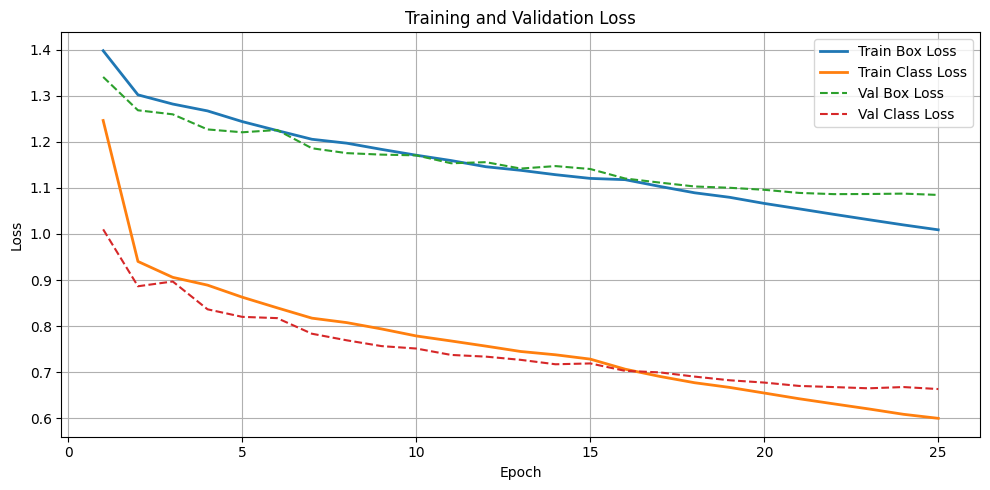

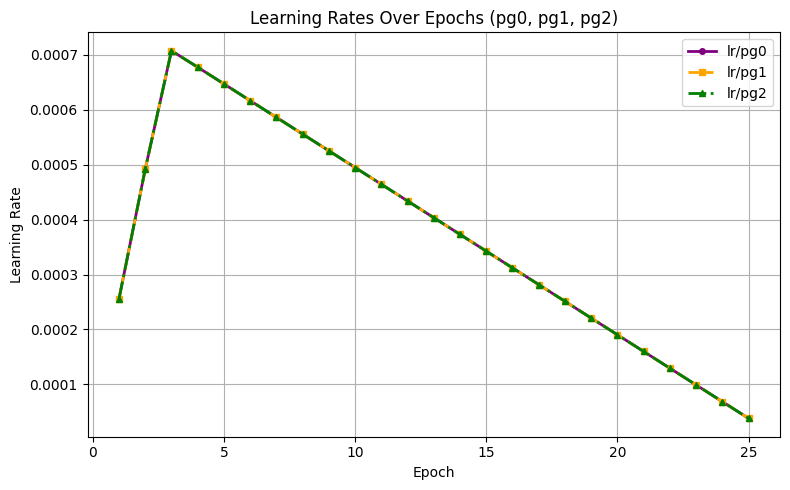

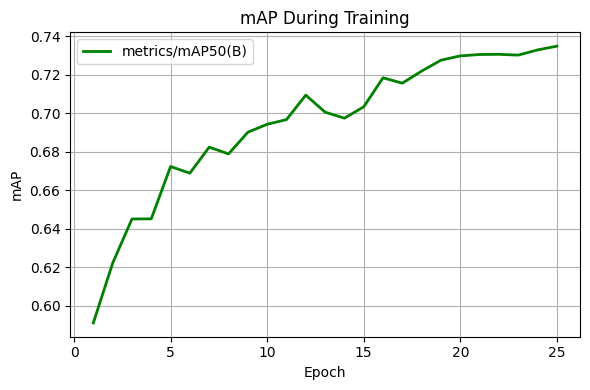

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

WORK2 = Path("/kaggle/working/traffic_ssl_vit/0_yolo_split") 

# Path to results.csv
results_path = WORK / "ssl_yolo12s_dinov2" / "results.csv"

# Load CSV
df = pd.read_csv(results_path)

# Show available columns
print("Available columns:", df.columns.tolist())

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss", linewidth=2)
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss", linewidth=2)
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss", linestyle="--")
plt.plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

lr_columns = [col for col in df.columns if col.startswith("lr/pg")]
colors = ['purple', 'orange', 'green']
styles = ['-', '--', '-.']
markers = ['o', 's', '^']

if lr_columns:
    plt.figure(figsize=(8, 5))
    for idx, col in enumerate(lr_columns):
        plt.plot(
            df["epoch"], df[col],
            label=col,
            color=colors[idx % len(colors)],
            linestyle=styles[idx % len(styles)],
            marker=markers[idx % len(markers)],
            markersize=4,
            linewidth=2
        )
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rates Over Epochs (pg0, pg1, pg2)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No learning rate columns found.")


# Plot mAP Curve (0.5 IoU)
map_keys = ["metrics/mAP50(B)", "metrics/mAP50-95(B)"]  # version dependent
map_column = next((key for key in map_keys if key in df.columns), None)

if map_column:
    plt.figure(figsize=(6, 4))
    plt.plot(df["epoch"], df[map_column], label=map_column, color="green", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("mAP")
    plt.title("mAP During Training")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("mAP column not found. Skipping mAP plot.")


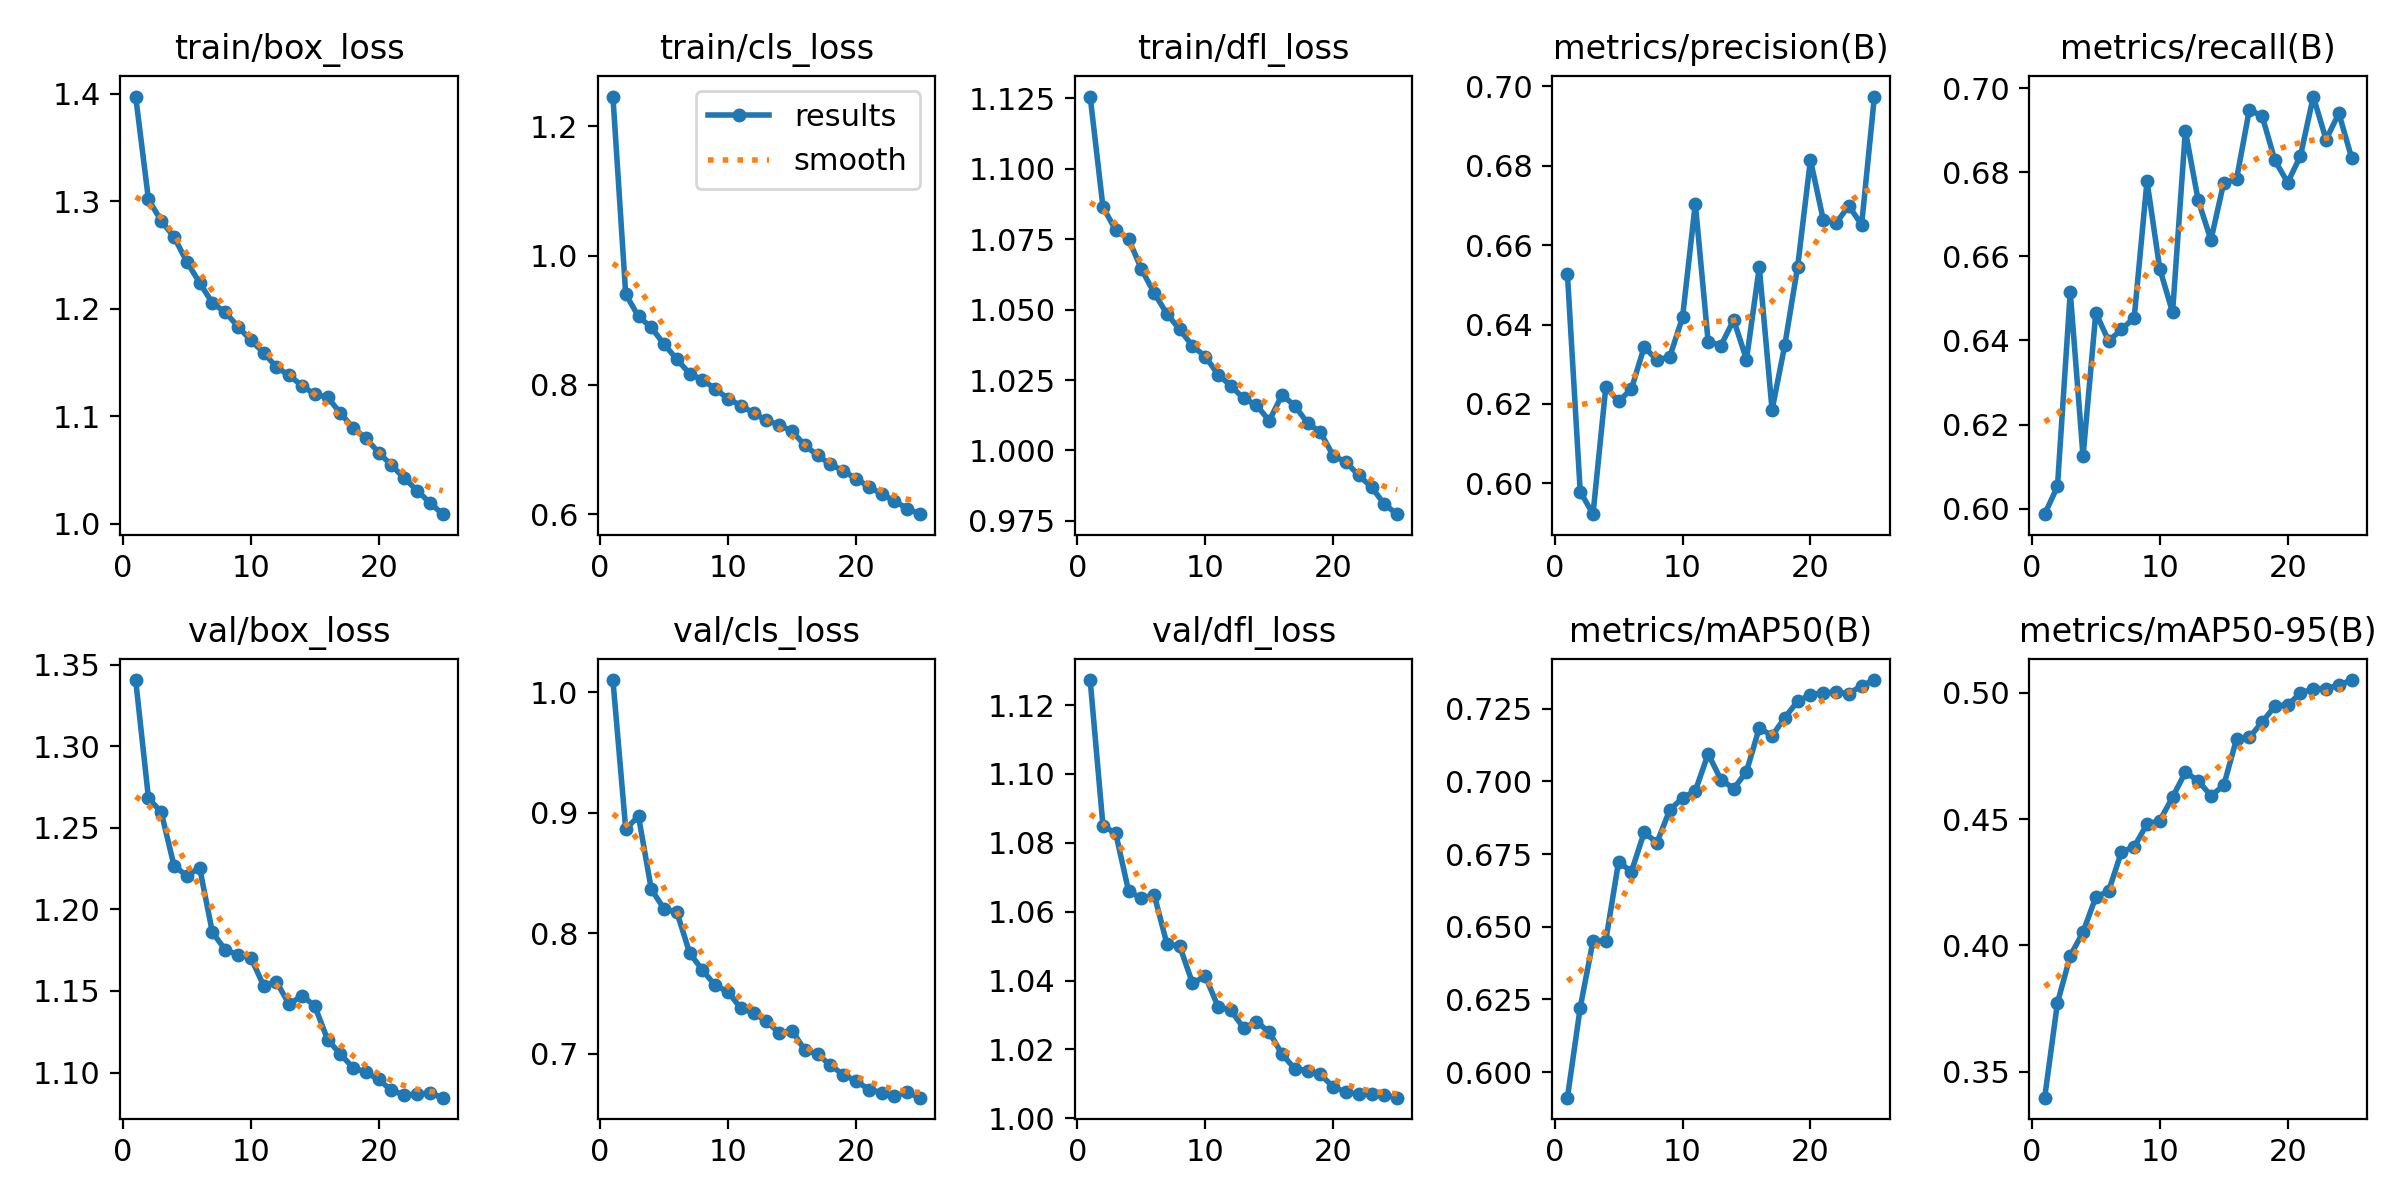

In [6]:
from PIL import Image
from IPython.display import display

results_img = WORK / "ssl_yolo12s_dinov2" / "results.png"
img = Image.open(results_img)
display(img)


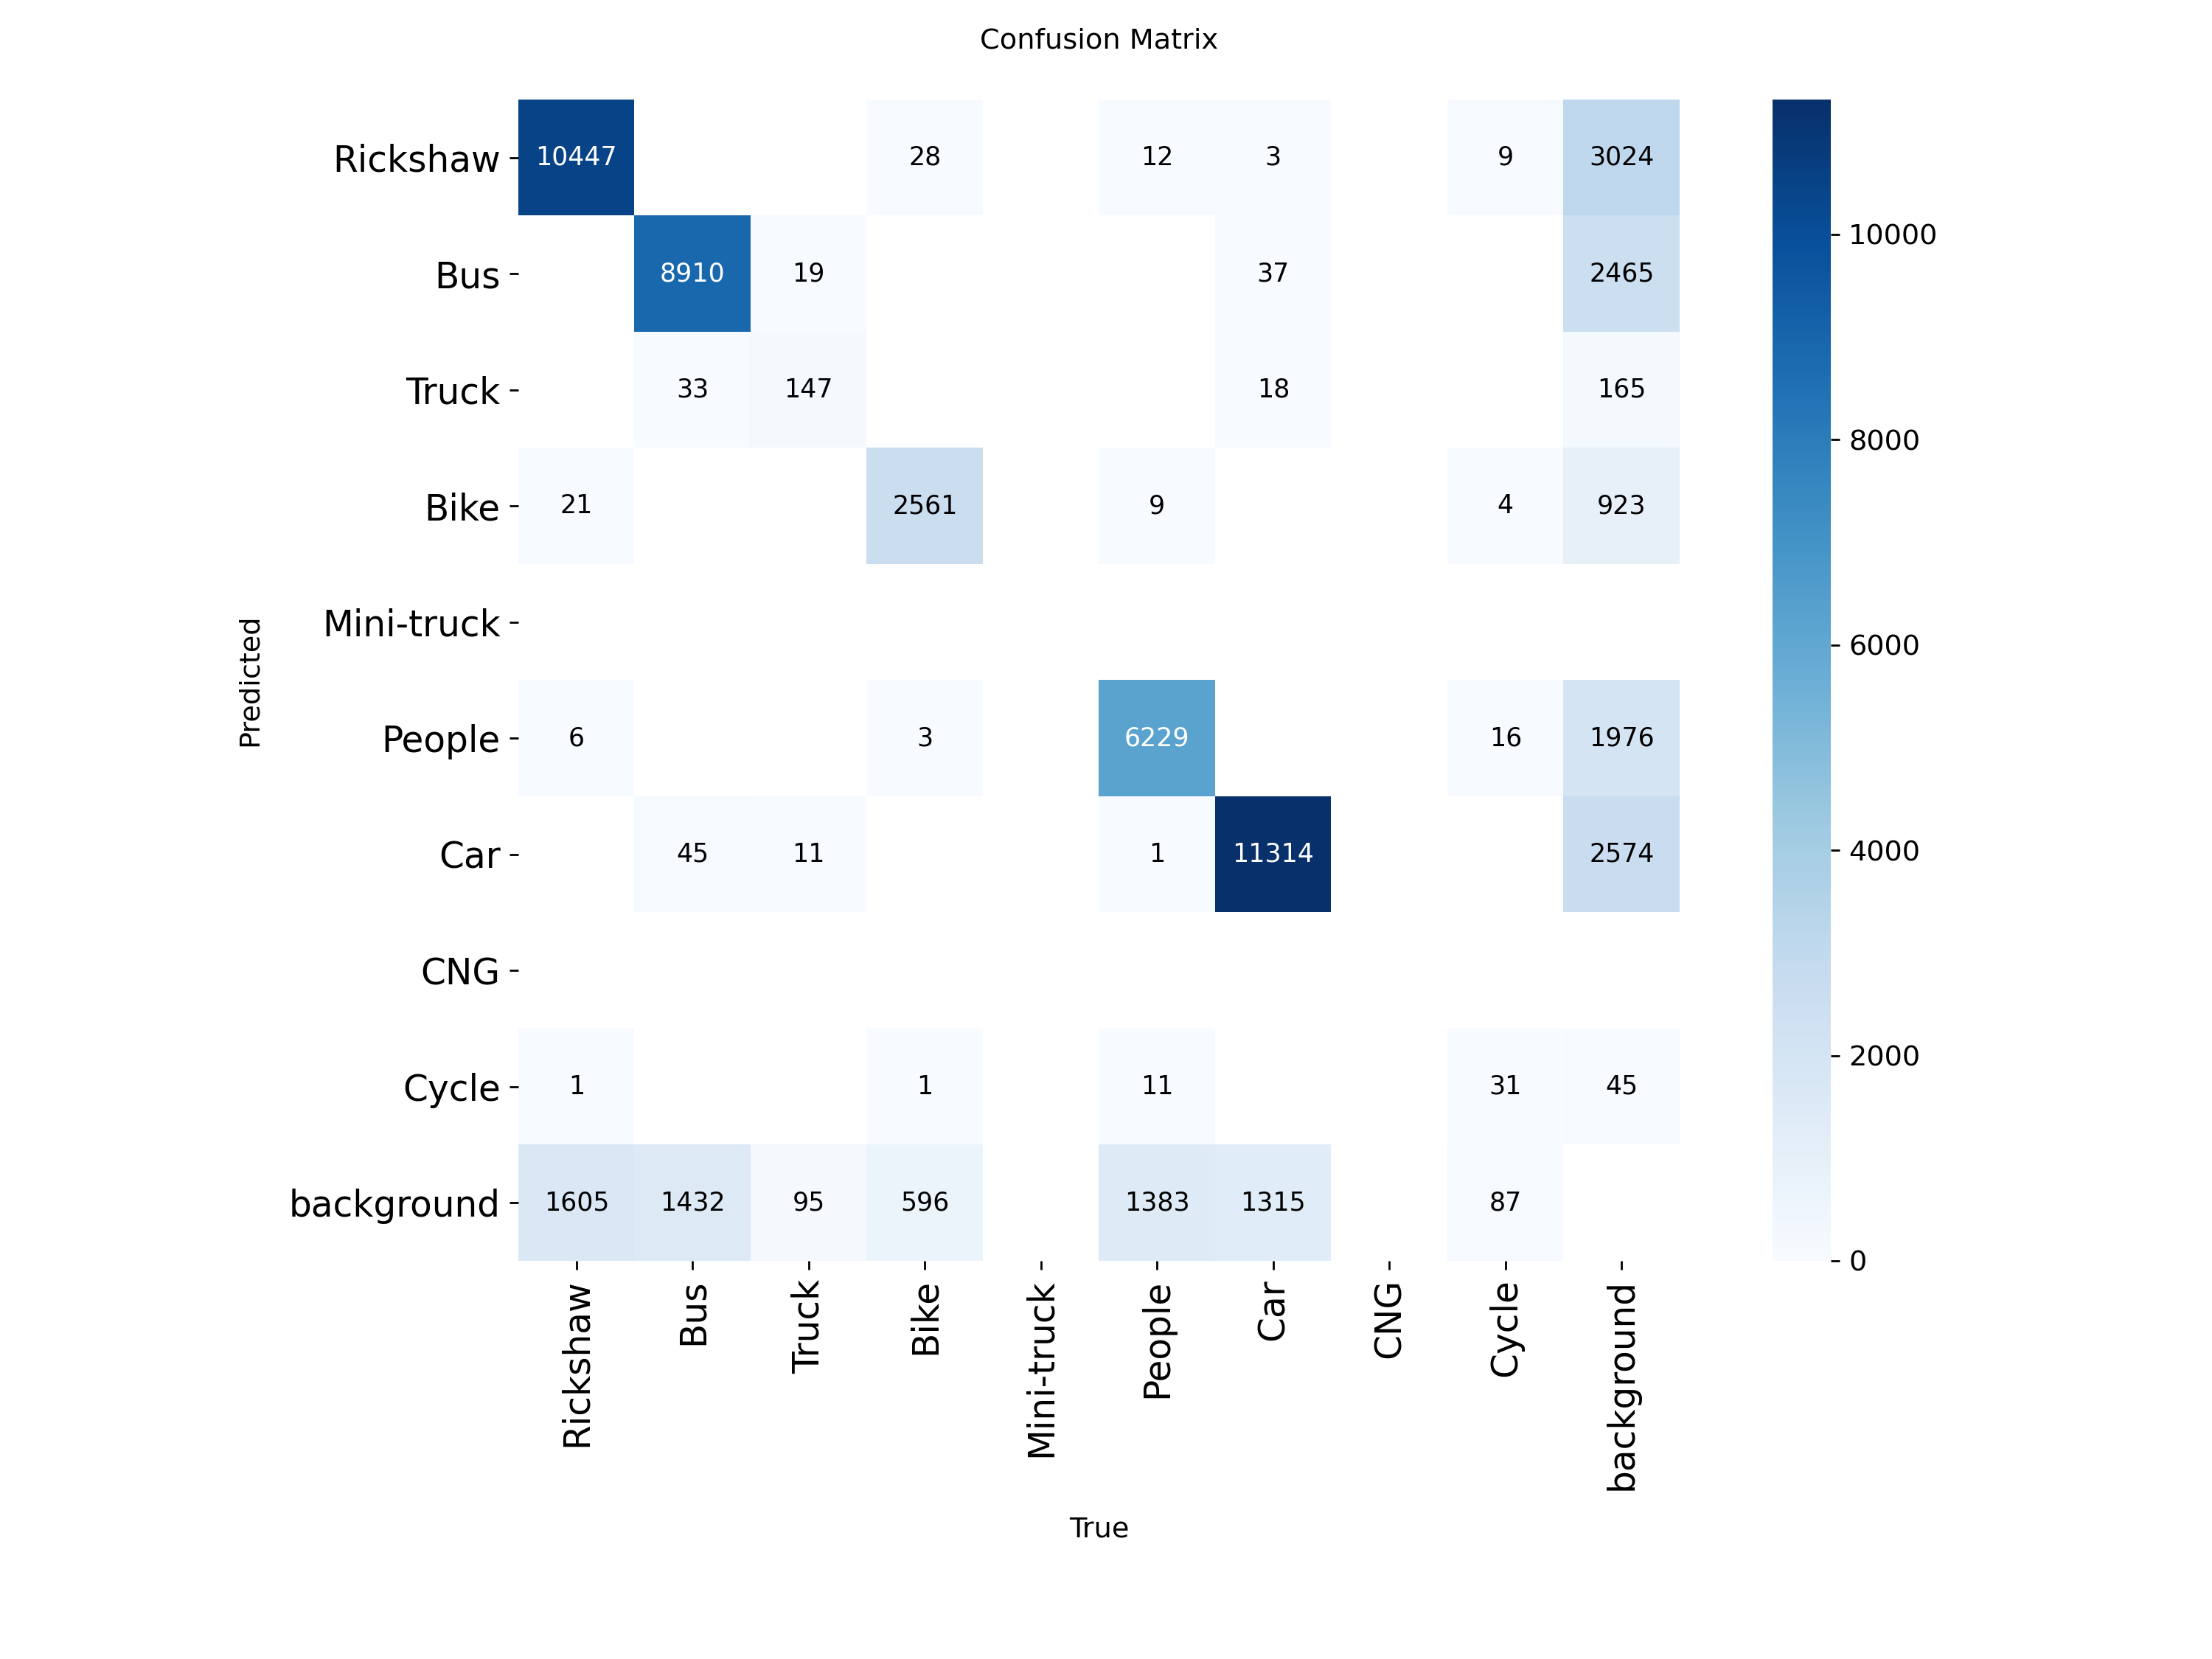

In [7]:
from PIL import Image
from IPython.display import display

results_img = WORK / "ssl_yolo12s_dinov2" / "confusion_matrix.png"
img = Image.open(results_img)
display(img)


Ultralytics 8.3.189 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,234,363 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1674.3±391.6 MB/s, size: 65.6 KB)
val: Scanning /kaggle/working/traffic_ssl_vit/0_yolo_split/valid/labels.cache... 4735 images, 14 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 4735/4735 7471794.4it/s 0.0s
val: /kaggle/working/traffic_ssl_vit/0_yolo_split/valid/images/frame1_jpg.rf.af73293c83d849389bfeacd60c71cd38.jpg: 1 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1184/1184 18.1it/s 1:05


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       4735      46440      0.696      0.684      0.735      0.505
              Rickshaw       3920      12080      0.798       0.84      0.903      0.627
                   Bus       3915      10420      0.804      0.827      0.892       0.65
                 Truck        247        272      0.446        0.5      0.447      0.343
                  Bike       2122       3189      0.757      0.771      0.836      0.509
                People       2913       7645      0.791      0.779      0.866      0.551
                   Car       4265      12687      0.839      0.872      0.933      0.701
                 Cycle        146        147       0.44      0.197      0.268      0.156
Speed: 0.2ms preprocess, 10.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val

Validation metrics
 Precision (mP) : 0.6963
 Recall    (mR) : 0.6839
 mAP@0.50      : 0.7350
 mAP@0.50-0.95 : 0.5052


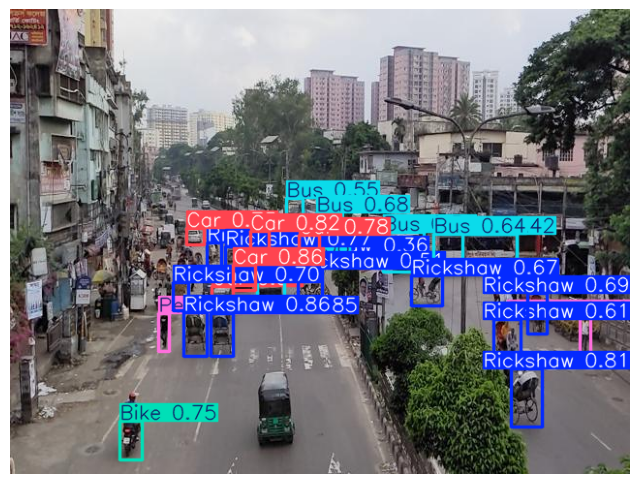

In [8]:
best_pt = WORK / "ssl_yolo12s_dinov2" / "weights" / "best.pt"
model_det = YOLO(str(best_pt))

results = model_det.val(data=str(DATA),
                        imgsz=640,
                        batch=4,
                        device=0 if device=="cuda" else "cpu")

try:
    mp, mr, map50, map5095 = results.mean_results()
except Exception:
    mp, mr = float(results.box.mp), float(results.box.mr)
    map50, map5095 = float(results.box.map50), float(results.box.map)




WORK3  = Path("/kaggle/working/traffic_ssl_vit/0_yolo_split")
print("\nValidation metrics")
print(f" Precision (mP) : {mp:.4f}")
print(f" Recall    (mR) : {mr:.4f}")
print(f" mAP@0.50      : {map50:.4f}")
print(f" mAP@0.50-0.95 : {map5095:.4f}")


# visualize a random test image
test_imgs = list((WORK3/"test/images").glob("*.*"))
if test_imgs:
    img_path = random.choice(test_imgs)
    pred = model_det.predict(source=str(img_path),
                             imgsz=640,
                             conf=0.25,
                             device=0 if device=="cuda" else "cpu",
                             verbose=False)[0]
    plt.figure(figsize=(8,8))
    plt.imshow(pred.plot()[:, :, ::-1])  # BGR->RGB
    plt.axis("off")
    plt.show()
else:
    print("No test images found for visualization.")